In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import json
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import os
import re
from scipy.stats import spearmanr, kruskal
import scikit_posthocs as sp
import warnings
import cellcharter as cc
from sklearn.linear_model import LinearRegression
warnings.filterwarnings('ignore')

/Users/lukashat/miniforge3/envs/cellcharter_scarches/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


In [2]:
extension = 'svg'
save_path = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/figure_4/{extension}/'
save_path_supp = f'/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/paper/plots/figures/suppl_figure_4/{extension}/'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
adata = ad.read_h5ad("/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/results/standard/adatas/cells_final.h5ad")
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/neighborhood_color_map.json', 'r') as f:
    neighborhood_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/phenotype_color_map.json', 'r') as f:
    phenotype_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease_color_map.json', 'r') as f:
    disease_color_map = json.load(f)
with open('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/Paper/figure_plots/disease3_color_map.json', 'r') as f:
    disease3_color_map = json.load(f)
neighborhood_colors = [neighborhood_color_map[cat] for cat in list(adata.obs['cellcharter_CN'].cat.categories)]
neighborhood_colors = ListedColormap(neighborhood_colors)
phenotype_colors = [phenotype_color_map[cat] for cat in list(adata.obs['Phenotype4'].cat.categories)]
phenotype_colors = ListedColormap(phenotype_colors)
disease_colors = [disease_color_map[cat] for cat in list(adata.obs['disease2'].cat.categories)]
disease_colors = ListedColormap(disease_colors)
disease3_colors = [disease3_color_map[cat] for cat in list(adata.obs['disease3'].cat.categories)]
disease3_colors = ListedColormap(disease3_colors)

In [3]:
disease = 'disease3'
disease_mapping = adata.obs[[disease, 'image_ID']].drop_duplicates()
disease_mapping.set_index('image_ID', inplace=True)

In [8]:
csv = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/dirSEA/250326COZI_grouped_immune_normalized.csv')
csv.rename(columns={'Unnamed: 0': 'image_ID'}, inplace=True)
csv['image_ID'] = csv['image_ID'].replace({'TS-373_IMC42_B_ROI_2.csv': 'TS-373_IMC42_B_002.csv'})
csv['disease3'] = csv['image_ID'].map(disease_mapping['disease3'])
disease_order = ['MM', 'SMM', 'MGUS']
csv[disease] = pd.Categorical(csv[disease], 
                                categories=disease_order, 
                                ordered=True)
csv = csv.sort_values(disease)

# A

In [9]:
targets = ['image_ID', 'Immune cells_Plasma Cells/MM cells']
pattern = '|'.join(map(re.escape, targets))
interactions = csv.filter(regex=pattern, axis=1)
interactions[disease] = interactions['image_ID'].map(disease_mapping[disease])
interactions[disease] = pd.Categorical(interactions[disease], 
                                categories=disease_order, 
                                ordered=True)
interactions = interactions.sort_values(disease)
interactions = interactions.replace([np.inf, -np.inf], np.nan)
interactions

,image_ID,Immune cells_Plasma Cells/MM cells,disease3
0,TS-373_IMC77_B_001.csv,0.257722,MM
7,TS-373_IMC35_B_002.csv,0.146578,MM
8,TS-373_IMC38_B_001.csv,-0.169136,MM
9,TS-373_IMC90.1_B_001.csv,-0.327384,MM
10,TS-373_IMC56_B_001.csv,-0.143497,MM
...,...,...,...
97,TS-373_IMC82_MGUS_002.csv,0.121173,MGUS
49,TS-373_IMC02_MGUS_001.csv,0.168106,MGUS
15,TS-373_IMC04_MGUS_001.csv,0.074026,MGUS
14,TS-373_IMC03_MGUS_001.csv,0.026112,MGUS


In [10]:
interactions.dropna(inplace=True)

In [11]:
interactions.rename(columns={'Immune cells_Plasma Cells/MM cells': 'Immune cells*PCs'}, inplace=True)

In [ ]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(36, 1))
ax_plot = sns.heatmap(interactions.drop(columns=['image_ID', disease]).T, cmap='coolwarm', center=0, cbar_kws={'label': 'z-score', 'shrink': 1.5, 'aspect': 5, 'pad': 0.07}, ax=ax, vmin=-0.15, vmax=0.15)
disease_colors = [disease3_color_map[d] for d in interactions[disease]]
ax_disease = fig.add_axes([ax.get_position().x0, 
                           ax.get_position().y1 + 0.01, 
                           ax.get_position().width, 
                           0.14])
ax_disease.imshow([disease_colors], 
                aspect='auto',
                extent=[0, len(disease_colors), 0, 1])
ax_disease.set_xticks([])
ax_disease.set_yticks([])
ax_disease.set_xticklabels('')
ax_plot.set_xlabel('')
ax_plot.set_xticklabels('')
ax_plot.set_yticklabels(ax_plot.get_yticklabels(), size=16)
if disease == 'disease3':
        legend_patches = [mpatches.Patch(color=color, label=disease_) 
                        for disease_, color in disease3_color_map.items()]
if disease == 'disease2':
        legend_patches = [mpatches.Patch(color=color, label=disease_) 
                        for disease_, color in disease_color_map.items()]
cbar = ax_plot.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)          # Tick labels
cbar.ax.yaxis.label.set_size(18) 
ax.legend(handles=legend_patches, 
        bbox_to_anchor=(1.0, 1.6),
        framealpha=0.0, 
        loc='upper left',
        title='Disease Cohort',
        title_fontsize=16,
        fontsize=14)
#plt.tight_layout()
plt.savefig(os.path.join(save_path, f'interaction_immune_tumor.{extension}'), bbox_inches='tight')

In [ ]:
interactions['Immune cells*PCs'].describe()

In [ ]:
interactions

In [ ]:
interactions

In [ ]:
sns.boxplot(data=interactions, x=disease, y='Immune cells*PCs', palette=disease3_color_map, showcaps=False, linewidth=2, width=0.75)

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
sns.kdeplot(data=interactions, x='Immune cells*PCs', hue=disease, palette=disease3_color_map, fill=True, alpha=0.5, linewidth=2, common_norm=False, ax=ax)
ax.set_xlabel('Immune cells*PCs score', fontsize=14)
ax.set_ylabel('Density', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
legend = ax.get_legend()
legend.set_title('')
for text in legend.get_texts():
	text.set_fontsize(14)
fig.tight_layout()
plt.savefig(os.path.join(save_path, f'interaction_immune_tumor_density.{extension}'), bbox_inches='tight')

# C

# Correlating max component size of PC_OXPHOS with immune-pc interactions cores

In [12]:
adata_cc = adata.copy()
cc.gr.connected_components(adata_cc, cluster_key='cellcharter_CN', min_cells=1)
adata_cc = adata_cc[~adata_cc.obs['component'].isna()]

In [13]:
count = adata_cc.obs['component'].value_counts().to_dict()

if 'shape_component' not in adata_cc.uns:
    adata_cc.uns['shape_component'] = {}
adata_cc.uns['shape_component']['count'] = count
df = pd.DataFrame(adata_cc.uns['shape_component']['count'].items(), columns=['component', 'count'])
df = pd.merge(df, adata_cc.obs[['component', 'image_ID']].drop_duplicates().dropna(), on='component')
df = pd.merge(df, adata_cc.obs[['component', 'cellcharter_CN']].drop_duplicates().dropna(), on='component')
df = pd.merge(df, adata_cc.obs[['component', 'disease3']].drop_duplicates().dropna(), on='component')

counts = adata_cc[~adata_cc.obs['component'].isna()].obs.groupby(['image_ID', 'cellcharter_CN']).size().reset_index(name='total_neighborhood_cells_image')
df = df.merge(counts, on=['image_ID', 'cellcharter_CN'], how='left')

unique_counts = (
    adata_cc.obs.groupby(["image_ID", "cellcharter_CN"])["component"]
    .nunique()
    .reset_index()
    .rename(columns={"component": "unique_components_neighborhood_image"})
)
df = df.merge(unique_counts, on=["image_ID", "cellcharter_CN"], how="left")
df = df[df['cellcharter_CN'] =='PC_OXPHOS']
df2 = df.groupby('image_ID').max('count')

In [14]:
merged = pd.merge(
    interactions,
    df2,
    left_on='image_ID',
    right_index=True)
merged.dropna(inplace=True)
merged['count'] = np.log(merged['count'])
merged

,image_ID,Immune cells*PCs,disease3,count,total_neighborhood_cells_image,unique_components_neighborhood_image
0,TS-373_IMC77_B_001.csv,0.257722,MM,4.605170,407.0,80.0
7,TS-373_IMC35_B_002.csv,0.146578,MM,2.484907,43.0,21.0
8,TS-373_IMC38_B_001.csv,-0.169136,MM,5.010635,865.0,109.0
9,TS-373_IMC90.1_B_001.csv,-0.327384,MM,6.182085,1305.0,71.0
10,TS-373_IMC56_B_001.csv,-0.143497,MM,5.043425,857.0,103.0
...,...,...,...,...,...,...
97,TS-373_IMC82_MGUS_002.csv,0.121173,MGUS,3.526361,106.0,49.0
49,TS-373_IMC02_MGUS_001.csv,0.168106,MGUS,2.639057,114.0,60.0
15,TS-373_IMC04_MGUS_001.csv,0.074026,MGUS,2.302585,184.0,103.0
14,TS-373_IMC03_MGUS_001.csv,0.026112,MGUS,4.369448,160.0,33.0


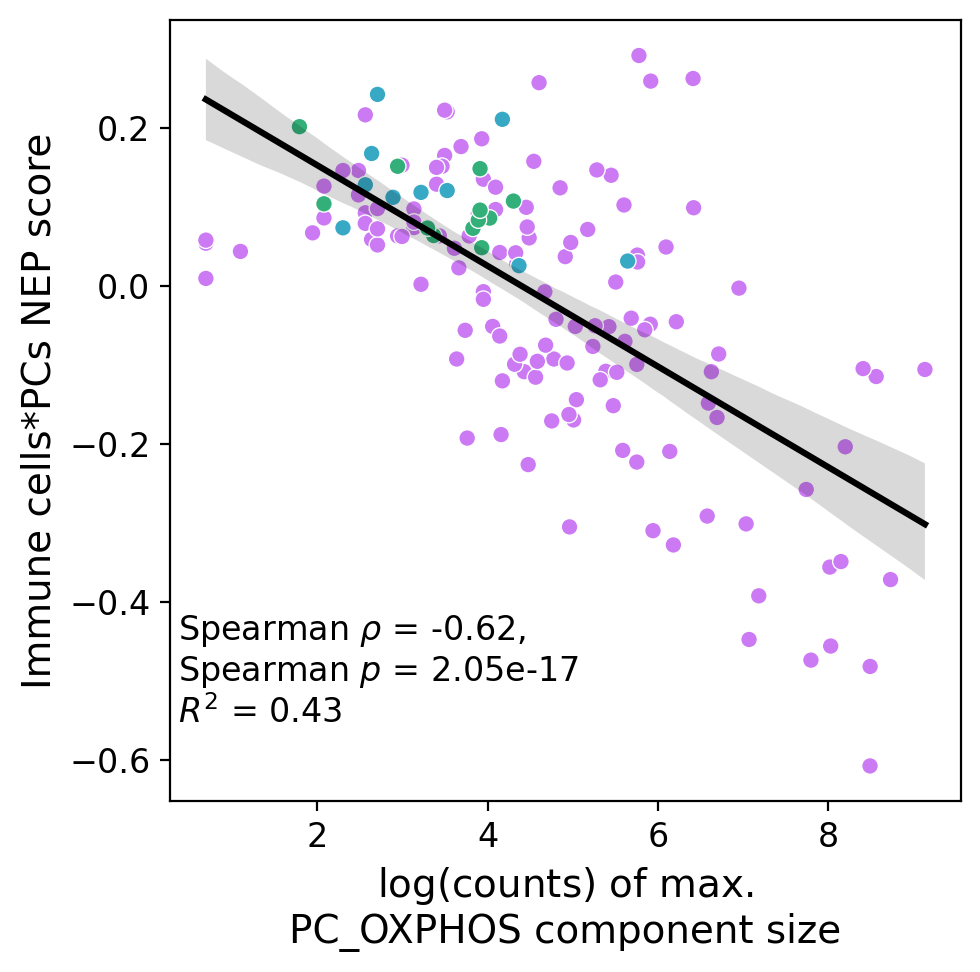

In [16]:
plt.style.use('default')
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x='count',
    y='Immune cells*PCs',
    data=merged,
    hue='disease3',
    palette=disease3_color_map,
    legend=False)
sns.regplot(
    x='count',
    y='Immune cells*PCs',
    data=merged,
    scatter=False,
    color='black'
)
# Select 'count' as a DataFrame (2D)
X = merged[['count']]
y = merged['Immune cells*PCs']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = model.score(X, y)
stat, p = spearmanr(merged['count'], merged['Immune cells*PCs'])
plt.text(0.01, 0.1, f'Spearman $\\rho$ = {stat:.2f}, \nSpearman $p$ = {p:.2e} \n$R^2$ = {r2:.2f}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel(r'$\log(\text{counts})$ of max.' + '\n' + r'PC_OXPHOS component size', fontsize=14)
plt.ylabel('Immune cells*PCs NEP score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'PC_immune_interaction_pc_oxphos_component_correlation.{extension}'))

In [29]:
df = pd.crosstab(
    index=adata.obs['image_ID'],
    columns= [adata.obs['cellcharter_CN'], adata.obs['Phenotype4']],
    #normalize='index'
)
df

cellcharter_CN            ADAPTIVE_IMMUNE                               \
Phenotype4                     Adipocytes CD4 T CD8 T  DCs Endothelial   
image_ID                                                                 
TS-373_IMC01_UB_001.csv                 0     1     9    3           0   
TS-373_IMC01_UB_002.csv                 2    53    82  100           2   
TS-373_IMC02_MGUS_001.csv               0     5     7    2           0   
TS-373_IMC02_MGUS_002.csv               0     7     9    4           0   
TS-373_IMC03_MGUS_001.csv               0     2     9    1           0   
...                                   ...   ...   ...  ...         ...   
TS-373_IMC93_B_002.csv                  0     3    41    0           0   
TS-373_IMC95_B_001.csv                  0     0     0    0           0   
TS-373_IMC95_B_002.csv                  0     0     1    0           0   
TS-373_IMC96_B_001.csv                  0     7     8    1           0   
TS-373_IMC96_B_002.csv                  0    22    43    9           0   

cellcharter_CN                                                      \
Phenotype4                HLA-DR+ Macs/monos HSPCs MPO+ Macs/monos   
image_ID                                                             
TS-373_IMC01_UB_001.csv                    9     0    1          2   
TS-373_IMC01_UB_002.csv                   36    21   57          4   
TS-373_IMC02_MGUS_001.csv                  5     0    1          0   
TS-373_IMC02_MGUS_002.csv                  6     0    1          1   
TS-373_IMC03_MGUS_001.csv                  3     1    4          0   
...                                      ...   ...  ...        ...   
TS-373_IMC93_B_002.csv                     3     0    1          3   
TS-373_IMC95_B_001.csv                     5     0    0          3   
TS-373_IMC95_B_002.csv                     4     0    8          1   
TS-373_IMC96_B_001.csv                    25     0    3          2   
TS-373_IMC96_B_002.csv                    22     0   11          0   

cellcharter_CN                         ...        PROLIF_GLYC             \
Phenotype4                Neutrophils  ... HLA-DR+ Macs/monos HSPCs MPO+   
image_ID                               ...                                 
TS-373_IMC01_UB_001.csv             0  ...                 78     5   39   
TS-373_IMC01_UB_002.csv            41  ...                 45     1   17   
TS-373_IMC02_MGUS_001.csv           1  ...                 87     3    6   
TS-373_IMC02_MGUS_002.csv           2  ...                 97     1   13   
TS-373_IMC03_MGUS_001.csv           6  ...                 52     3   49   
...                               ...  ...                ...   ...  ...   
TS-373_IMC93_B_002.csv              2  ...                 10    21    5   
TS-373_IMC95_B_001.csv             17  ...                 38     2   13   
TS-373_IMC95_B_002.csv             11  ...                 24     2  194   
TS-373_IMC96_B_001.csv             12  ...                108     5   28   
TS-373_IMC96_B_002.csv             45  ...                231     9  235   

cellcharter_CN                                                          \
Phenotype4                Macs/monos Neutrophils OB/RUNX2+ Osteoclasts   
image_ID                                                                 
TS-373_IMC01_UB_001.csv           79          86         1           0   
TS-373_IMC01_UB_002.csv           28          32         0           0   
TS-373_IMC02_MGUS_001.csv         31          74         2           0   
TS-373_IMC02_MGUS_002.csv         51          67         0           0   
TS-373_IMC03_MGUS_001.csv         41          67         0           0   
...                              ...         ...       ...         ...   
TS-373_IMC93_B_002.csv            79          38         3           1   
TS-373_IMC95_B_001.csv           145         278         0           0   
TS-373_IMC95_B_002.csv            46         355         1           0   
TS-373_IMC96_B_001.csv       

In [ ]:
PC_OXPHOS_ratio = df.xs('PC_OXPHOS', axis=1, level=0)['PCs'].div(df.xs('PCs', axis=1, level=1).sum(axis=1))

In [ ]:
merge = pd.merge(
    interactions,
    pd.DataFrame(PC_OXPHOS_ratio),
    left_on='image_ID',
    right_index=True
)
merge.rename(columns={0: 'PC_OXPHOS_ratio'}, inplace=True)
merge

In [ ]:
sns.scatterplot(
    x='PC_OXPHOS_ratio',
    y='Immune cells*PCs',
    data=merge,
    hue=disease,
    palette= disease3_color_map if disease == 'disease3' else disease_color_map
)
sns.regplot(
    x='PC_OXPHOS_ratio',
    y='Immune cells*PCs',
    data=merge,
    scatter=False,
    color='black'
)
correlation,p = spearmanr(merge['PC_OXPHOS_ratio'], merged['Immune cells*PCs'])
plt.text(0.01, 0.05, f'Spearman $\\rho$={correlation:.2f}\nSpearman p={p:.2e}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('ratio of PCs in PC_OXPHOS', fontsize=14)
plt.ylabel('Immune cells*PCs normalized score', fontsize=14)
plt.legend(title='', framealpha=0, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'pc_oxphos_ratio_interaction_zscore.{extension}'))

In [ ]:
PC_MYELOID_ratio = df.xs('PC_MYELOID', axis=1, level=0)['PCs'].div(df.xs('PCs', axis=1, level=1).sum(axis=1))
merge = pd.merge(
    interactions,
    pd.DataFrame(PC_MYELOID_ratio),
    left_on='image_ID',
    right_index=True
)
merge.rename(columns={0: 'PC_MYELOID_ratio'}, inplace=True)
merge

In [ ]:
sns.scatterplot(
    x='PC_MYELOID_ratio',
    y='Immune cells*PCs',
    data=merge,
    hue=disease,
    palette= disease3_color_map if disease == 'disease3' else disease_color_map
)
sns.regplot(
    x='PC_MYELOID_ratio',
    y='Immune cells*PCs',
    data=merge,
    scatter=False,
    color='black'
)
correlation,p = spearmanr(merge['PC_MYELOID_ratio'], merged['Immune cells*PCs'])
plt.text(0.2, 0.05, f'Spearman $\\rho$={correlation:.2f}\nSpearman p={p:.2e}', transform=plt.gca().transAxes, fontsize=12)
plt.xlabel('ratio of PCs in PC_MYELOID', fontsize=14)
plt.ylabel('Immune cells*PCs normalized score', fontsize=14)
plt.legend(title='', framealpha=0, fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'pc_myeloid_ratio_interaction_zscore.{extension}'))

# D

In [ ]:
# cc.gr.connected_components(adata, cluster_key='cellcharter_CN', min_cells=60)
# adata = adata[~adata.obs['component'].isna()]

In [ ]:
markers = ['ATP5A', 'GLUT1', 'PKM2', 'CPT1A', 'CD36', 'CD98', 'HIF1A', 'Ki67', 'CS', 'GranzymeK', 'IDO', 'HLA-DR']

In [ ]:
markers = ['GranzymeK', 'CD36']
celltype = 'CD8 T'
cell = adata[adata.obs['Phenotype4'] == celltype]
cell_subset = cell[cell.obs[f'cellcharter_CN'].isin(['PC_OXPHOS', 'PC_MYELOID', 'HIF1A_IMMUNE', 'ADAPTIVE_IMMUNE'])].copy()
df = cell_subset.to_df()
df['cellcharter_CN'] = cell_subset.obs['cellcharter_CN']
df['image_ID'] = cell_subset.obs['image_ID']
df2 = df.groupby(['cellcharter_CN', 'image_ID']).median().reset_index().dropna()
df2[disease] = df2['image_ID'].map(disease_mapping[disease])
with plt.rc_context({"figure.figsize": (3, 3)}):
    for marker in markers:
        axes = sns.violinplot(x='cellcharter_CN', y=marker, data=df2,
                              #hue = disease,
                              #hue_order=disease_order,
                              palette=neighborhood_color_map,
                              scale='width',
                              inner='box')
        axes.set_title(f'')
        
        # Get current y-axis limits
        ymin, ymax = axes.get_ylim()
        # Set new y-axis limits with 0.5 added to the max limit
        axes.set_ylim(0, 1.1)
        axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=12)
        axes.set_yticklabels(axes.get_yticklabels(), fontsize=12)
        axes.set_ylabel(f'{marker} (CLR)', fontsize=14)
        axes.set_xlabel('')
        
        
        fig = axes.figure
        fig.savefig(os.path.join(save_path, f'violin_{celltype}_{marker}_per_image_neighborhoods.{extension}'), 
                    dpi=300, 
                    bbox_inches='tight',
                    pad_inches=0.1)
        plt.close(fig)

In [ ]:
target_neighborhoods = ['PC_OXPHOS', 'PC_MYELOID', 'HIF1A_IMMUNE', 'ADAPTIVE_IMMUNE']
filtered_df = df2[df2['cellcharter_CN'].isin(target_neighborhoods)]
groups = [group['CD36'].values for _, group in filtered_df.groupby('cellcharter_CN')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")


In [ ]:
dunn_results = sp.posthoc_dunn(
    filtered_df, 
    val_col='CD36',
    group_col='cellcharter_CN',
    p_adjust='bonferroni'
)
print("\nDunn's posthoc results:")
dunn_results

In [ ]:
markers = ['HLA-DR', 'IDO']
celltype = 'DCs'
cell = adata[adata.obs['Phenotype4'] == celltype]
cell_subset = cell[cell.obs[f'cellcharter_CN'].isin(['PC_OXPHOS', 'PC_MYELOID', 'HIF1A_IMMUNE', 'ADAPTIVE_IMMUNE'])].copy()
df = cell_subset.to_df()
df['cellcharter_CN'] = cell_subset.obs['cellcharter_CN']
df['image_ID'] = cell_subset.obs['image_ID']
df2 = df.groupby(['cellcharter_CN', 'image_ID']).median().reset_index().dropna()
df2[disease] = df2['image_ID'].map(disease_mapping[disease])
with plt.rc_context({"figure.figsize": (3, 3)}):
    for marker in markers:
        axes = sns.violinplot(x='cellcharter_CN', y=marker, data=df2,
                              #hue = disease,
                              #hue_order=disease_order,
                              palette=neighborhood_color_map,
                              scale='width',
                              inner='box')
        axes.set_title(f'')
        
        # Get current y-axis limits
        ymin, ymax = axes.get_ylim()
        # Set new y-axis limits with 0.5 added to the max limit
        axes.set_ylim(0, 1.1)
        axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=12)
        axes.set_yticklabels(axes.get_yticklabels(), fontsize=12)
        axes.set_ylabel(f'{marker} (CLR)', fontsize=14)
        axes.set_xlabel('')
        
        
        fig = axes.figure
        fig.savefig(os.path.join(save_path, f'violin_{celltype}_{marker}_per_image_neighborhoods.{extension}'), 
                    dpi=300, 
                    bbox_inches='tight',
                    pad_inches=0.1)
        plt.close(fig)

In [ ]:
target_neighborhoods = ['PC_OXPHOS', 'PC_MYELOID', 'HIF1A_IMMUNE', 'ADAPTIVE_IMMUNE']
filtered_df = df2[df2['cellcharter_CN'].isin(target_neighborhoods)]
groups = [group['HLA-DR'].values for _, group in filtered_df.groupby('cellcharter_CN')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")


In [ ]:
dunn_results = sp.posthoc_dunn(
    filtered_df, 
    val_col='HLA-DR',
    group_col='cellcharter_CN',
    p_adjust='bonferroni'
)
print("\nDunn's posthoc results:")
dunn_results

In [ ]:
markers = ['HLA-DR', 'IDO']
celltype = 'HLA-DR+ Macs/monos'
cell = adata[adata.obs['Phenotype4'] == celltype]
cell_subset = cell[cell.obs[f'cellcharter_CN'].isin(['PC_OXPHOS', 'PC_MYELOID', 'HIF1A_IMMUNE', 'ADAPTIVE_IMMUNE'])].copy()
df = cell_subset.to_df()
df['cellcharter_CN'] = cell_subset.obs['cellcharter_CN']
df['image_ID'] = cell_subset.obs['image_ID']
df2 = df.groupby(['cellcharter_CN', 'image_ID']).median().reset_index().dropna()
df2[disease] = df2['image_ID'].map(disease_mapping[disease])
with plt.rc_context({"figure.figsize": (3, 3)}):
    for marker in markers:
        axes = sns.violinplot(x='cellcharter_CN', y=marker, data=df2,
                              #hue = disease,
                              #hue_order=disease_order,
                              palette=neighborhood_color_map,
                              scale='width',
                              inner='box')
        axes.set_title(f'')
        
        # Get current y-axis limits
        ymin, ymax = axes.get_ylim()
        # Set new y-axis limits with 0.5 added to the max limit
        axes.set_ylim(0, 1.1)
        axes.set_xticklabels(axes.get_xticklabels(), rotation=90, fontsize=12)
        axes.set_yticklabels(axes.get_yticklabels(), fontsize=12)
        axes.set_ylabel(f'{marker} (CLR)', fontsize=14)
        axes.set_xlabel('')
        
        
        fig = axes.figure
        fig.savefig(os.path.join(save_path, f'violin_HLA-DR+_Macs_monos_{marker}_per_image_neighborhoods.{extension}'), 
                    dpi=300, 
                    bbox_inches='tight',
                    pad_inches=0.1)
        plt.close(fig)

In [ ]:
target_neighborhoods = ['PC_OXPHOS', 'PC_MYELOID', 'HIF1A_IMMUNE', 'ADAPTIVE_IMMUNE']
filtered_df = df2[df2['cellcharter_CN'].isin(target_neighborhoods)]
groups = [group['HLA-DR'].values for _, group in filtered_df.groupby('cellcharter_CN')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")


In [ ]:
dunn_results = sp.posthoc_dunn(
    filtered_df, 
    val_col='HLA-DR',
    group_col='cellcharter_CN',
    p_adjust='bonferroni'
)
print("\nDunn's posthoc results:")
dunn_results

In [ ]:
target_neighborhoods = ['PC_OXPHOS', 'PC_MYELOID', 'HIF1A_IMMUNE', 'ADAPTIVE_IMMUNE']
filtered_df = df2[df2['cellcharter_CN'].isin(target_neighborhoods)]
groups = [group['IDO'].values for _, group in filtered_df.groupby('cellcharter_CN')]
kruskal_result = kruskal(*groups)
print(f"Kruskal-Wallis H-stat: {kruskal_result.statistic:.3f}, p-val: {kruskal_result.pvalue:.4f}")


In [ ]:
dunn_results = sp.posthoc_dunn(
    filtered_df, 
    val_col='IDO',
    group_col='cellcharter_CN',
    p_adjust='bonferroni'
)
print("\nDunn's posthoc results:")
dunn_results

# Suppl

In [4]:
csv = pd.read_csv('/Users/lukashat/Documents/PhD_Schapiro/Projects/Myeloma_Standal/github/myeloma_standal/src/downstream/dirSEA/250326COZI_phenotype4_normalized.csv')
csv.rename(columns={'Unnamed: 0': 'image_ID'}, inplace=True)
csv['image_ID'] = csv['image_ID'].replace({'TS-373_IMC42_B_ROI_2.csv': 'TS-373_IMC42_B_002.csv'})
csv['disease3'] = csv['image_ID'].map(disease_mapping['disease3'])
disease_order = ['MM', 'SMM', 'MGUS']
csv[disease] = pd.Categorical(csv[disease], 
                                categories=disease_order, 
                                ordered=True)
csv = csv.sort_values(disease)

In [5]:
csv

,image_ID,Adipocytes_Adipocytes,Adipocytes_CD4+Tcells,Adipocytes_CD8+Tcells,Adipocytes_Dendritic Cells,Adipocytes_Endothelial cells,Adipocytes_HSCs,Adipocytes_MPO+,Adipocytes_Macrophages/Monocytes,Adipocytes_Neutrophils,...,activated Macrophages/Monocytes_MPO+,activated Macrophages/Monocytes_Macrophages/Monocytes,activated Macrophages/Monocytes_Neutrophils,activated Macrophages/Monocytes_Osteoblast lineage,activated Macrophages/Monocytes_Osteoclasts,activated Macrophages/Monocytes_Osteocyte,activated Macrophages/Monocytes_Plasma Cells/MM cells,activated Macrophages/Monocytes_Unknown,activated Macrophages/Monocytes_activated Macrophages/Monocytes,disease3
0,TS-373_IMC77_B_001.csv,0.054949,-0.042442,-0.000054,NaN,0.006039,-0.026232,0.014985,0.060071,-0.051738,...,0.019165,0.092099,-0.026314,-0.008306,-0.012124,-0.117433,0.114973,-0.032708,0.063877,MM
105,TS-373_IMC21_UB_001.csv,0.034301,0.005272,0.010980,0.002747,0.005436,-0.003420,0.012120,-0.011077,-0.020731,...,-0.005321,-0.007377,0.006617,0.023049,NaN,NaN,0.027454,-0.007226,0.003930,MM
103,TS-373_IMC23_B_001.csv,0.138062,0.007359,0.001083,0.001052,0.099965,0.026831,0.032193,-0.011739,0.011867,...,0.033997,0.087018,-0.000263,0.264465,-0.000171,-0.008859,0.082941,0.003609,0.057084,MM
102,TS-373_IMC84_B_001.csv,-0.003560,-0.012934,0.004016,0.016152,0.001742,-0.008884,0.051858,-0.004245,0.031954,...,0.054746,0.019665,0.043223,0.073215,-0.009592,-0.014934,-0.062951,0.073967,0.008179,MM
101,TS-373_IMC89_B_002.csv,0.062778,0.026117,-0.015520,-0.008118,0.068501,0.016743,0.048815,-0.016813,-0.003726,...,-0.007921,0.060564,0.039770,0.070293,-0.004395,-0.170510,0.064585,0.005122,0.016453,MM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,TS-373_IMC02_MGUS_001.csv,-0.000866,-0.004810,-0.006109,0.000664,-0.000168,-0.069226,0.015348,-0.005204,-0.006568,...,0.037875,0.016573,-0.003498,-0.004544,NaN,NaN,0.065531,0.014382,0.115971,MGUS
15,TS-373_IMC04_MGUS_001.csv,0.022918,0.009822,-0.008635,-0.005738,0.041603,0.011743,0.000531,0.009509,-0.006564,...,0.014710,0.031651,0.027893,-0.011331,NaN,-0.006276,0.022336,0.039426,0.245442,MGUS
14,TS-373_IMC03_MGUS_001.csv,0.009342,-0.011293,0.007123,0.007675,0.001907,0.026948,0.036456,-0.012364,-0.001750,...,0.008551,0.081314,0.014049,-0.005200,NaN,0.190955,-0.006998,0.056182,0.247597,MGUS
35,TS-373_IMC02_MGUS_002.csv,0.025271,-0.005002,0.019977,-0.005995,0.014078,0.001149,0.003653,-0.015298,-0.011692,...,-0.007048,0.071532,0.090328,-0.004056,NaN,0.220669,0.063302,0.020959,0.157729,MGUS


In [6]:
targets = ['image_ID', 'CD8+Tcells_Plasma Cells/MM cells', 'CD4+Tcells_Plasma Cells/MM cells', 'Dendritic Cells_Plasma Cells/MM cells', 'activated Macrophages/Monocytes_Plasma Cells/MM cells', 'Neutrophils_Plasma Cells/MM cells',
           'Macrophages/Monocytes_Plasma Cells/MM cells']
pattern = '|'.join(map(re.escape, targets))
interactions = csv.filter(regex=pattern, axis=1)
interactions[disease] = interactions['image_ID'].map(disease_mapping[disease])
interactions[disease] = pd.Categorical(interactions[disease], 
                                categories=disease_order, 
                                ordered=True)
interactions = interactions.sort_values(disease)
interactions = interactions.replace([np.inf, -np.inf], np.nan)
interactions

,image_ID,CD4+Tcells_Plasma Cells/MM cells,CD8+Tcells_Plasma Cells/MM cells,Dendritic Cells_Plasma Cells/MM cells,Macrophages/Monocytes_Plasma Cells/MM cells,Neutrophils_Plasma Cells/MM cells,activated Macrophages/Monocytes_Plasma Cells/MM cells,disease3
0,TS-373_IMC77_B_001.csv,0.026666,0.108408,NaN,0.100689,0.175820,0.114973,MM
7,TS-373_IMC35_B_002.csv,0.034445,0.081197,0.006491,0.109167,0.086356,0.072948,MM
8,TS-373_IMC38_B_001.csv,-0.074097,-0.053526,-0.032461,-0.031050,-0.100721,-0.069406,MM
9,TS-373_IMC90.1_B_001.csv,-0.046553,-0.043821,-0.039406,-0.035886,-0.330908,0.003570,MM
10,TS-373_IMC56_B_001.csv,-0.034829,-0.098023,0.000268,-0.037690,-0.102854,-0.046146,MM
...,...,...,...,...,...,...,...,...
97,TS-373_IMC82_MGUS_002.csv,0.030952,0.057040,-0.009923,0.012615,0.057370,0.089195,MGUS
49,TS-373_IMC02_MGUS_001.csv,0.013602,0.049994,0.026209,0.033117,0.125424,0.065531,MGUS
15,TS-373_IMC04_MGUS_001.csv,0.036873,0.028668,0.036007,-0.011365,0.045641,0.022336,MGUS
14,TS-373_IMC03_MGUS_001.csv,-0.012705,0.063379,0.003028,0.023786,0.010532,-0.006998,MGUS


In [7]:
interactions.rename(columns={'CD8+Tcells_Plasma Cells/MM cells': 'CD8 Tcells*PCs','CD4+Tcells_Plasma Cells/MM cells': 'CD4 Tcells*PCs', 'Dendritic Cells_Plasma Cells/MM cells': 'DCs*PCs',
                             'activated Macrophages/Monocytes_Plasma Cells/MM cells': 'HLA-DR+ Macs/monos*PCs', 'Neutrophils_Plasma Cells/MM cells': 'Neutrophils*PCs', 'Macrophages/Monocytes_Plasma Cells/MM cells': 'Macs/monos*PCs'}, inplace=True)
interactions

,image_ID,CD4 Tcells*PCs,CD8 Tcells*PCs,DCs*PCs,Macs/monos*PCs,Neutrophils*PCs,HLA-DR+ Macs/monos*PCs,disease3
0,TS-373_IMC77_B_001.csv,0.026666,0.108408,NaN,0.100689,0.175820,0.114973,MM
7,TS-373_IMC35_B_002.csv,0.034445,0.081197,0.006491,0.109167,0.086356,0.072948,MM
8,TS-373_IMC38_B_001.csv,-0.074097,-0.053526,-0.032461,-0.031050,-0.100721,-0.069406,MM
9,TS-373_IMC90.1_B_001.csv,-0.046553,-0.043821,-0.039406,-0.035886,-0.330908,0.003570,MM
10,TS-373_IMC56_B_001.csv,-0.034829,-0.098023,0.000268,-0.037690,-0.102854,-0.046146,MM
...,...,...,...,...,...,...,...,...
97,TS-373_IMC82_MGUS_002.csv,0.030952,0.057040,-0.009923,0.012615,0.057370,0.089195,MGUS
49,TS-373_IMC02_MGUS_001.csv,0.013602,0.049994,0.026209,0.033117,0.125424,0.065531,MGUS
15,TS-373_IMC04_MGUS_001.csv,0.036873,0.028668,0.036007,-0.011365,0.045641,0.022336,MGUS
14,TS-373_IMC03_MGUS_001.csv,-0.012705,0.063379,0.003028,0.023786,0.010532,-0.006998,MGUS


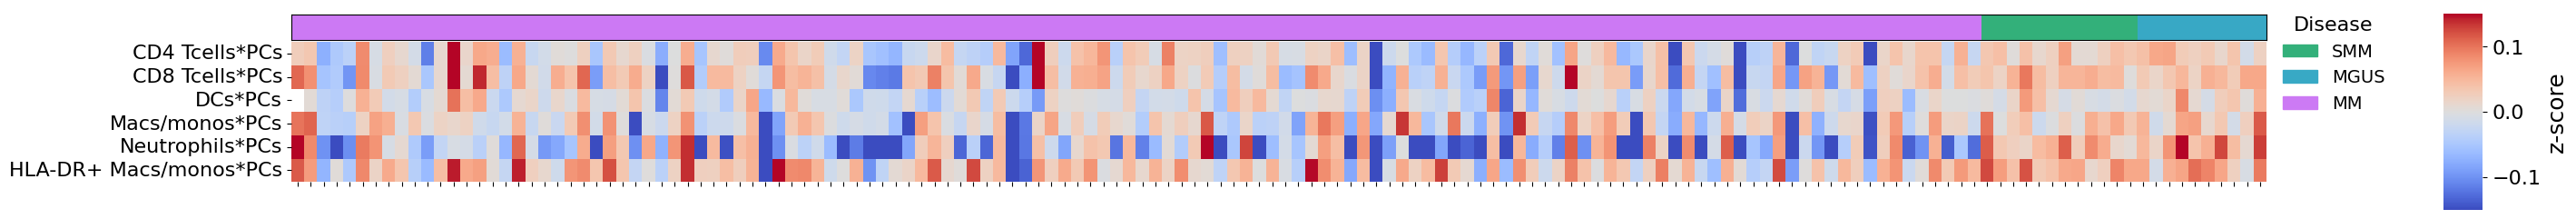

In [15]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(36, 2))
ax_plot = sns.heatmap(interactions.drop(columns=['image_ID', disease]).T, cmap='coolwarm', center=0, cbar_kws={'label': 'z-score', 'shrink': 1.4, 'aspect': 5, 'pad': 0.07}, ax=ax, vmin=-0.15, vmax=0.15)
disease_colors = [disease3_color_map[d] for d in interactions[disease]]
ax_disease = fig.add_axes([ax.get_position().x0, 
                           ax.get_position().y1 + 0.01, 
                           ax.get_position().width, 
                           0.14])
ax_disease.imshow([disease_colors], 
                aspect='auto',
                extent=[0, len(disease_colors), 0, 1])
ax_disease.set_xticks([])
ax_disease.set_yticks([])
ax_disease.set_xticklabels('')
ax_plot.set_xlabel('')
ax_plot.set_xticklabels('')
ax_plot.set_yticklabels(ax_plot.get_yticklabels(), size=16)
if disease == 'disease3':
        legend_patches = [mpatches.Patch(color=color, label=disease_) 
                        for disease_, color in disease3_color_map.items()]
if disease == 'disease2':
        legend_patches = [mpatches.Patch(color=color, label=disease_) 
                        for disease_, color in disease_color_map.items()]
cbar = ax_plot.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)          # Tick labels
cbar.ax.yaxis.label.set_size(18) 
ax.legend(handles=legend_patches, 
        bbox_to_anchor=(1.0, 1.3),
        framealpha=0.0, 
        loc='upper left',
        title='Disease',
        title_fontsize=16,
        fontsize=14)
#plt.tight_layout()
plt.savefig(os.path.join(save_path_supp, f'interaction_all_immune_tumor.{extension}'), bbox_inches='tight')